In [1]:
!pwd

/root/shared


In [2]:
!ls

Test_notebook.ipynb			Untitled.ipynb	    notes-FEniCSx_files
Test_tutorial_docker_version.ipynb	notes-FEniCSx.html
Test_tutorial_docker_version.ipynb.zip	notes-FEniCSx.qmd


In [3]:
!which python3

/usr/bin/python3


In [4]:
!python3 --version

Python 3.10.6


In [5]:
import pyvista

ModuleNotFoundError: No module named 'pyvista'

In [6]:
!python3 -m pip install "https://github.com/finsberg/vtk-aarch64/releases/download/vtk-9.2.6-cp310/vtk-9.2.6.dev0-cp310-cp310-linux_aarch64.whl"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 MB 5.2 MB/s eta 0:00:0000:0100:01m

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [7]:
!pip install pyvista

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 10.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [8]:
from mpi4py import MPI
from dolfinx import mesh
domain = mesh.create_unit_square(MPI.COMM_WORLD, 8, 8, mesh.CellType.quadrilateral)

In [9]:
from dolfinx.fem import FunctionSpace
V = FunctionSpace(domain, ("CG", 1))

In [10]:
from dolfinx import fem
uD = fem.Function(V)
uD.interpolate(lambda x: 1 + x[0]**2 + 2 * x[1]**2)

In [11]:
import numpy
# Create facet to cell connectivity required to determine boundary facets
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

In [12]:
boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(uD, boundary_dofs)

In [13]:
import ufl
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

In [14]:
from petsc4py.PETSc import ScalarType
f = fem.Constant(domain, ScalarType(-6))

In [15]:
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

In [16]:
problem = fem.petsc.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

In [17]:
V2 = fem.FunctionSpace(domain, ("CG", 2))
uex = fem.Function(V2)
uex.interpolate(lambda x: 1 + x[0]**2 + 2 * x[1]**2)

In [18]:
L2_error = fem.form(ufl.inner(uh - uex, uh - uex) * ufl.dx)
error_local = fem.assemble_scalar(L2_error)
error_L2 = numpy.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))

In [19]:
error_max = numpy.max(numpy.abs(uD.x.array-uh.x.array))
# Only print the error on one process
if domain.comm.rank == 0:
    print(f"Error_L2 : {error_L2:.2e}")
    print(f"Error_max : {error_max:.2e}")

Error_L2 : 8.24e-03
Error_max : 2.66e-15


In [20]:
import pyvista
print(pyvista.global_theme.jupyter_backend)

panel


In [21]:
from dolfinx import plot
pyvista.start_xvfb()
topology, cell_types, geometry = plot.create_vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

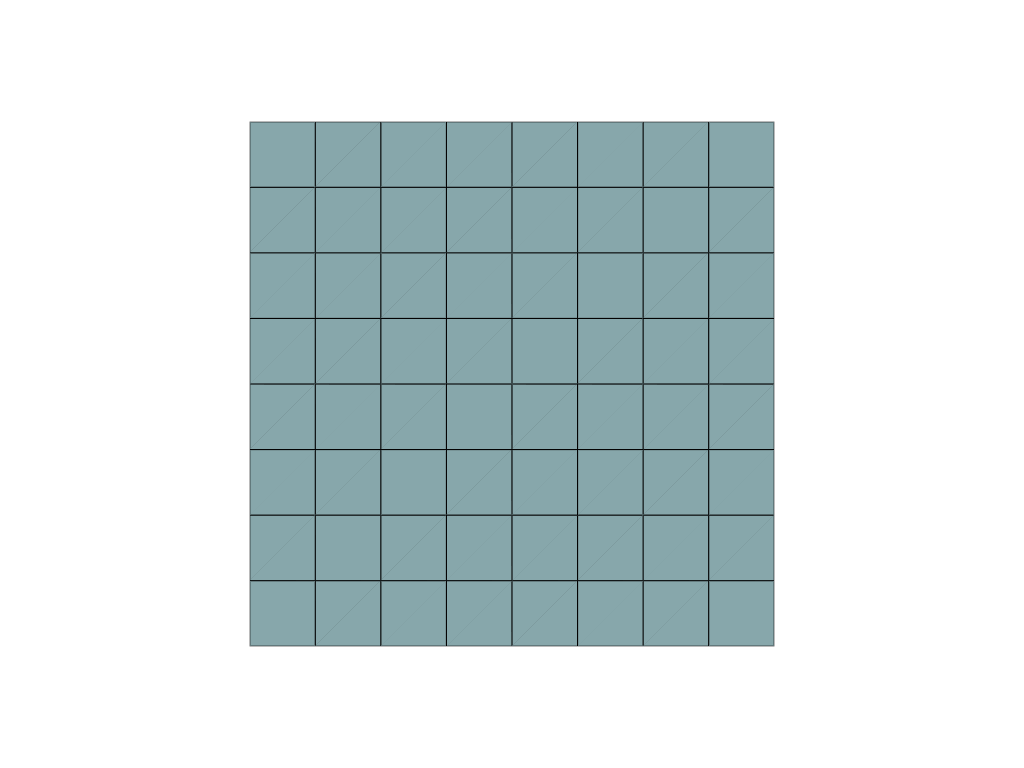

In [22]:
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

In [23]:
u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(V)

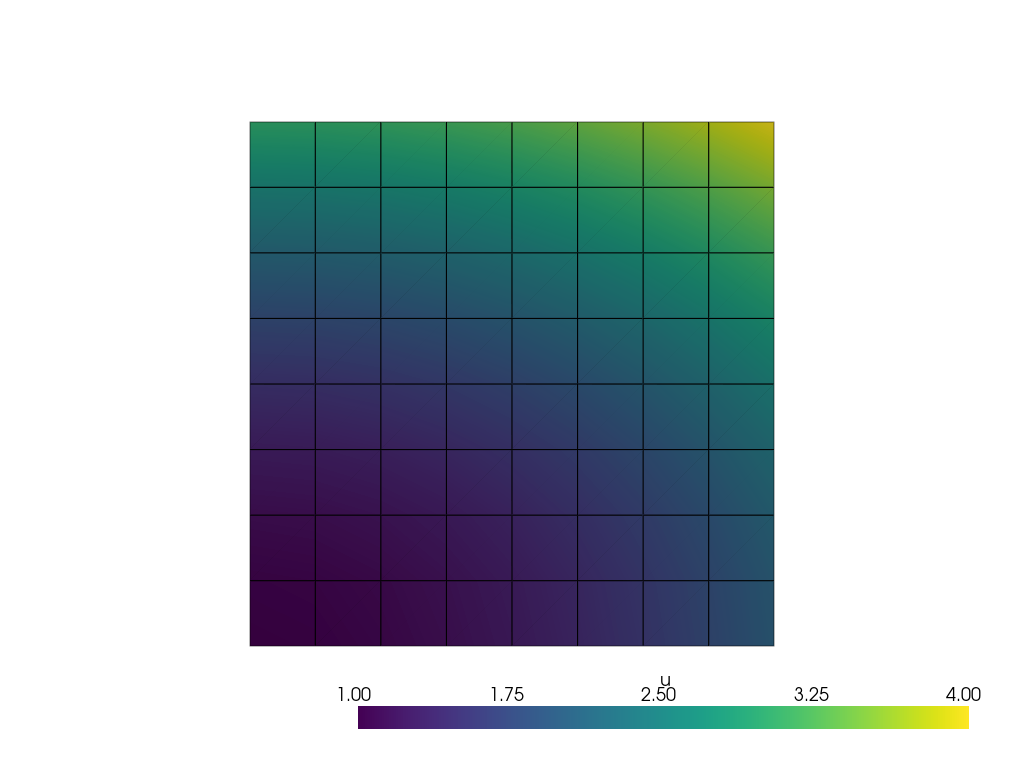

In [24]:
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

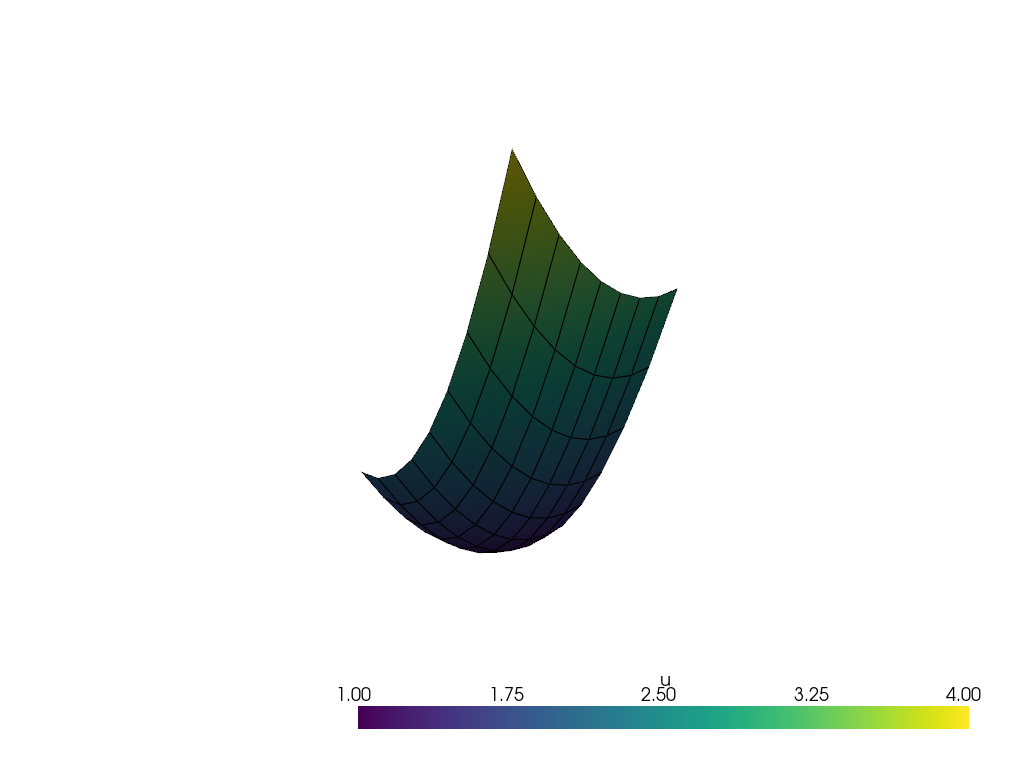

In [25]:
warped = u_grid.warp_by_scalar()
plotter2 = pyvista.Plotter()
plotter2.add_mesh(warped, show_edges=True, show_scalar_bar=True)
if not pyvista.OFF_SCREEN:
    plotter2.show()

In [26]:
from dolfinx import io
with io.VTXWriter(domain.comm, "output.bp", [uh]) as vtx:
    vtx.write(0.0)
with io.XDMFFile(domain.comm, "output.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(uh)